# Task 3 : CUR – Dimensionality Reduction

This task focuses on applying the CUR algorithm for dimensionality reduction. Using the features and labels generated in Task 2, a CUR decomposition model is implemented as a PySpark class to reduce the feature space from 10 dimensions down to 5.

## Rerunning the preprocessing process to get data of task 2

In [6]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, to_date, lag, monotonically_increasing_id
from pyspark.sql.types import ArrayType, DoubleType # For UDF output if returning array
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors as MLLibVectors # mllib Vectors
from pyspark.ml.linalg import Vectors as MLVectors, VectorUDT # ml Vectors
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler # Reuse from Task 2 if needed
from pyspark.ml.regression import LinearRegression # Reuse from Task 2
from pyspark.ml.evaluation import RegressionEvaluator # Reuse from Task 2
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("GoldPricePrediction").getOrCreate()

# 1. Load Data and Preprocessing
# Read the CSV file
try:
    df = spark.read.csv(
        "gold_prices.csv", # Make sure this file is in the same directory or provide the full path
        header=True,
        inferSchema=True
    )
except Exception as e:
    print(f"Error reading the CSV file: {e}")
    spark.stop()
    exit()

# Rename columns to remove spaces and ensure consistency
df = df.withColumnRenamed("Buy Price", "BuyPrice") \
       .withColumnRenamed("Sell Price", "SellPrice")

# Convert 'Date' column to date type
df = df.withColumn("Date", to_date(col("Date"), "yyyy/MM/dd"))

# Filter out rows with null dates if any, and sort by date
df = df.filter(col("Date").isNotNull()).orderBy("Date")

# For this task, we will use 'SellPrice' as the target gold price.
# Let's also ensure the prices are numeric (double or float).
df = df.withColumn("SellPrice", col("SellPrice").cast("double"))
df = df.withColumn("BuyPrice", col("BuyPrice").cast("double"))

# Drop rows with null prices if they exist after casting
df = df.dropna(subset=["SellPrice"])

# Add an index column to preserve order for window functions
df = df.withColumn("index", monotonically_increasing_id())

# 2. Generate Features and Labels
# Define a window specification ordered by 'Date' and then 'index'
window_spec = Window.orderBy("Date", "index")

# Create lagged columns for the previous 10 days' SellPrice
# The label will be the current day's 'SellPrice'
df_features = df.withColumn("label", col("SellPrice"))

# Generate features: gold prices of 10 consecutive previous dates
feature_cols = []
for i in range(1, 11):
    feature_name = f"price_lag_{i}"
    # lag("SellPrice", i) means price from i days ago
    df_features = df_features.withColumn(feature_name, lag("SellPrice", i).over(window_spec))
    feature_cols.append(feature_name)

# Remove rows with null values in features (these will be the first 10 rows due to lag)
df_features = df_features.dropna(subset=feature_cols)

if df_features.count() == 0:
    print("No data available after feature engineering. This might be due to insufficient data points for the 10-day lag or issues with data.")
    df.show(15) # Show some initial data for debugging
    spark.stop()
    exit()

# 3. Prepare Data for Spark ML
# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip") # Added handleInvalid
df_assembled = assembler.transform(df_features)

# Select only 'features' and 'label' columns
final_df = df_assembled.select("features", "label")

# 4. Split Data into Training and Test Sets
train_df, test_df = final_df.randomSplit([0.7, 0.3], seed=42)

# Cache the dataframes for performance
train_df.cache()
test_df.cache()

if train_df.count() == 0 or test_df.count() == 0:
    print("Training or testing dataframe is empty after split. Check data and feature engineering steps.")
    print(f"Total samples before split: {final_df.count()}")
    print(f"Training samples: {train_df.count()}, Test samples: {test_df.count()}")
    spark.stop()
    exit()

def get_task2_data(spark):
    """
    This function encapsulates the data loading and preprocessing steps from Task 2
    to produce the train_df_task2 and test_df_task2 DataFrames.
    """
    try:
        # --- Steps from Task 2 ---
        # 1. Load Data
        df = spark.read.csv(
            "gold_prices.csv",  # Ensure this file is accessible
            header=True,
            inferSchema=True
        )

        # 2. Initial Preprocessing
        df = df.withColumnRenamed("Buy Price", "BuyPrice") \
               .withColumnRenamed("Sell Price", "SellPrice")
        df = df.withColumn("Date", to_date(col("Date"), "yyyy/MM/dd"))
        df = df.filter(col("Date").isNotNull()).orderBy("Date")
        df = df.withColumn("SellPrice", col("SellPrice").cast("double"))
        # Add BuyPrice casting if it's used in features, otherwise not strictly necessary for SellPrice prediction
        # df = df.withColumn("BuyPrice", col("BuyPrice").cast("double"))
        df = df.dropna(subset=["SellPrice"]) # Ensure target price is not null

        # Add an index for robust window function ordering if dates could be duplicated
        # or if you prefer an explicit sequence for lagging.
        df = df.withColumn("index", monotonically_increasing_id())

        # 3. Feature and Label Generation
        window_spec = Window.orderBy("Date", "index")
        df_features = df.withColumn("label", col("SellPrice")) # Label is current SellPrice

        # Generate features: gold prices of 10 consecutive previous dates
        feature_cols_task2_names = []
        for i in range(1, 11):  # For 10 previous dates
            feature_name = f"price_lag_{i}"
            df_features = df_features.withColumn(feature_name, lag("SellPrice", i).over(window_spec))
            feature_cols_task2_names.append(feature_name)

        # Drop rows with nulls in features (first 10 rows after lagging)
        df_features = df_features.dropna(subset=feature_cols_task2_names)

        if df_features.count() == 0:
            print("Warning: No data available after feature engineering in get_task_2_data.")
            # Fallback to truly dummy data if CSV processing results in empty df
            data = [(MLVectors.dense([float(i) + j for j in range(10)]), float(i) + 10) for i in range(20)] # Minimal data
            schema_dd = ["features_original_dim", "label"]
            final_df_task2_assembled = spark.createDataFrame(data, schema_dd)
            feature_cols_task2_names = [f"feature_{i}" for i in range(10)]

        else:
            # 4. Assemble Features into a Vector
            assembler = VectorAssembler(inputCols=feature_cols_task2_names, outputCol="features_original_dim", handleInvalid="skip")
            df_assembled = assembler.transform(df_features)
            # Select only the features vector and the label
            final_df_task2_assembled = df_assembled.select(col("features_original_dim").alias("features"), "label")


        # 5. Split Data
        train_df_task2, test_df_task2 = final_df_task2_assembled.randomSplit([0.7, 0.3], seed=42)

        # Cache for performance as these will be reused
        train_df_task2.cache()
        test_df_task2.cache()

        # Ensure counts are checked after caching and splitting
        if train_df_task2.count() == 0:
             print("Critical Warning: Training data is empty after get_task2_data processing and split.")
        if test_df_task2.count() == 0:
             print("Warning: Test data is empty after get_task2_data processing and split.")

        return train_df_task2, test_df_task2, feature_cols_task2_names

    except Exception as e:
        print(f"Error during get_task2_data: {e}")
        print("Falling back to minimal dummy data for Task 3 due to error in Task 2 data preparation.")
        # Create truly dummy data if any step above fails critically
        # This helps Task 3 structure run, even if data is meaningless
        data = [(MLVectors.dense([float(i) + j for j in range(10)]), float(i) + 10) for i in range(20)] # Need at least some data
        schema_dd = ["features", "label"]
        dummy_df = spark.createDataFrame(data, schema_dd)
        train_df_task2, test_df_task2 = dummy_df.randomSplit([0.7, 0.3], seed=42)
        feature_cols_task2_names = [f"feature_{i}" for i in range(10)] # Placeholder names
        return train_df_task2, test_df_task2, feature_cols_task2_names


## CURReducer Class Definition


In [7]:
class CURReducer:
    def __init__(self, k):
        self.k = k  # Number of columns to select
        self.selected_indices = None
        self.original_feature_names = None # Optional: for understanding which features were selected

    def fit(self, df_train, features_col="features", feature_names=None):
        """
        Fits the CUR reducer by selecting top k columns based on squared L2 norm.
        Args:
            df_train (DataFrame): Training DataFrame with a features column.
            features_col (str): Name of the column containing feature vectors (pyspark.ml.linalg.Vector).
            feature_names (list, optional): List of original feature names for context.
        """
        # Convert pyspark.ml.linalg.Vector to pyspark.mllib.linalg.Vector for RowMatrix
        rdd_mllib_vectors = df_train.select(features_col).rdd.map(
            lambda row: MLLibVectors.fromML(row[0])
        )

        if rdd_mllib_vectors.isEmpty():
            raise ValueError("RDD of MLLib vectors is empty. Cannot fit CURReducer.")

        row_matrix = RowMatrix(rdd_mllib_vectors)

        # Compute column summary statistics
        summary_stats = row_matrix.computeColumnSummaryStatistics()

        # Get L2 norm for each column
        # summary_stats.normL2() returns a DenseVector (mllib) or potentially already a NumPy array
        col_L2_norms = summary_stats.normL2() # This appears to be already a NumPy array

        # Calculate squared L2 norms (proportional to sum of squares for each column)
        # Use NumPy operations for efficiency since col_L2_norms is already an array
        col_sum_squares = np.square(col_L2_norms)

        # Get indices of top k columns
        # argsort sorts in ascending order, so we take the last k indices from sorted
        sorted_indices = np.argsort(col_sum_squares)
        self.selected_indices = sorted_indices[-self.k:].tolist()
        # To maintain original order if important, or sort them:
        self.selected_indices.sort()

        print(f"Selected top {self.k} column indices (0-based): {self.selected_indices}")

        if feature_names and len(feature_names) == len(col_sum_squares):
            self.original_feature_names = feature_names
            selected_feature_names = [feature_names[i] for i in self.selected_indices]
            print(f"Corresponding selected feature names: {selected_feature_names}")


    def transform(self, df, features_col="features"):
        """
        Transforms the feature vectors in the DataFrame to the selected k dimensions.
        Args:
            df (DataFrame): DataFrame to transform.
            features_col (str): Name of the features column.
        Returns:
            DataFrame: Transformed DataFrame with a new column 'features_cur'
                       containing the reduced k-dimensional feature vectors.
        """
        if self.selected_indices is None:
            raise RuntimeError("CURReducer has not been fitted yet. Call fit() first.")

        selected_indices_broadcast = spark.sparkContext.broadcast(self.selected_indices)

        def extract_selected_features(vector):
            # vector is pyspark.ml.linalg.Vector
            if vector is None:
                return None
            # Convert to numpy array to easily select by index
            np_array = vector.toArray()
            return MLVectors.dense([np_array[i] for i in selected_indices_broadcast.value])

        # Register UDF
        # The output type is a Vector, so we use VectorUDT
        extract_udf = udf(extract_selected_features, VectorUDT())

        transformed_df = df.withColumn("features_cur", extract_udf(col(features_col)))
        return transformed_df

Schema of original training data from Task 2:
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

Number of training samples (Task 2): 3964
Number of testing samples (Task 2): 1591

Training Linear Regression on Original 10-dim features (from Task 2)...
Task 2 - Original 10-dim features - Train RMSE: 0.2737
Task 2 - Original 10-dim features - Test RMSE: 0.3567

Fitting CURReducer on training data...
Selected top 5 column indices (0-based): [0, 1, 2, 3, 4]
Corresponding selected feature names: ['price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5']
Transforming training data...
Transforming test data...

Schema of CUR-reduced training data:
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

+-------------------------------+-----+
|features                       |label|
+-------------------------------+-----+
|[21.19,21.19,21.19,21.19,21.19]|21.19|
|[21.19,21.19,21.19,21.19,21.19]|21.19|
|[21.19,21.19,21.1

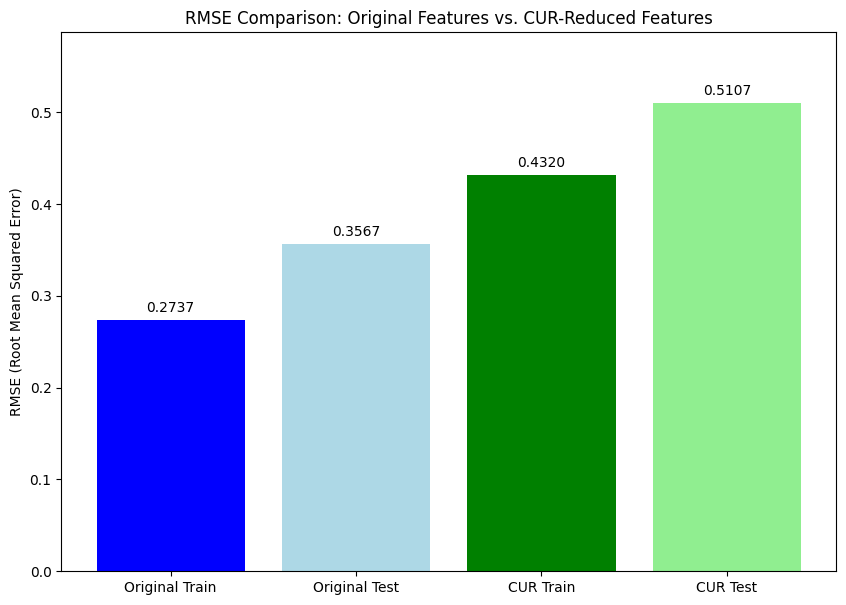

In [8]:
# --- Main script ---
if __name__ == "__main__":
    # It's assumed that SparkSession (spark) might be already created
    # but the traceback suggests running this as a new script cell.
    # Ensure spark is initialized if not already.
    try:
        spark = SparkSession.builder.appName("CURDimensionalityReduction").getOrCreate()
    except Exception as e:
         print(f"Could not get or create SparkSession: {e}")
         exit()


    # 1. Get Data from Task 2 (or simulate its output)
    #    This should provide train_df_task2 and test_df_task2 with a 'features' column (10-dim)
    #    and a 'label' column.
    #    It also provides original feature names for context (optional).
    train_df_task2, test_df_task2, original_feature_names = get_task2_data(spark)

    print("Schema of original training data from Task 2:")
    train_df_task2.printSchema()
    print(f"Number of training samples (Task 2): {train_df_task2.count()}")
    print(f"Number of testing samples (Task 2): {test_df_task2.count()}")

    # Add a check to ensure dataframes are not empty before proceeding
    if train_df_task2.count() == 0:
        print("Stopping because training data from Task 2 is empty.")
        spark.stop()
        exit()
    if test_df_task2.count() == 0:
        print("Warning: Test data from Task 2 is empty. Evaluation on test set will be skipped.")


    # --- Evaluate Linear Regression on Original 10-dim features (from Task 2) ---
    # Only attempt training/evaluation if training data is available
    if train_df_task2.count() > 0:
        print("\nTraining Linear Regression on Original 10-dim features (from Task 2)...")
        lr_task2 = LinearRegression(featuresCol="features", labelCol="label", solver="l-bfgs") # Use l-bfgs
        try:
            lr_model_task2 = lr_task2.fit(train_df_task2)

            predictions_train_task2 = lr_model_task2.transform(train_df_task2)
            evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
            train_rmse_task2 = evaluator_rmse.evaluate(predictions_train_task2)
            print(f"Task 2 - Original 10-dim features - Train RMSE: {train_rmse_task2:.4f}")

            test_rmse_task2 = float('nan') # Initialize with NaN in case test data is empty
            if test_df_task2.count() > 0:
                 predictions_test_task2 = lr_model_task2.transform(test_df_task2)
                 test_rmse_task2 = evaluator_rmse.evaluate(predictions_test_task2)
                 print(f"Task 2 - Original 10-dim features - Test RMSE: {test_rmse_task2:.4f}")
            else:
                 print("Skipping evaluation on original test set as it's empty.")

        except Exception as e:
            print(f"Error training or evaluating LR on original features: {e}")
            train_rmse_task2 = float('nan')
            test_rmse_task2 = float('nan')
            lr_model_task2 = None # Ensure model is None if training failed
    else:
        print("Skipping training/evaluation on original features as training data is empty.")
        train_rmse_task2 = float('nan')
        test_rmse_task2 = float('nan')
        lr_model_task2 = None


    # 2. Implement CUR and Reduce Dimensionality
    k_dimensions = 5
    cur_reducer = CURReducer(k=k_dimensions)

    # Fit CUR on the training data from Task 2
    print("\nFitting CURReducer on training data...")
    try:
        cur_reducer.fit(train_df_task2, features_col="features", feature_names=original_feature_names)

        # Transform training and test sets
        print("Transforming training data...")
        train_df_cur = cur_reducer.transform(train_df_task2, features_col="features")
        print("Transforming test data...")
        test_df_cur = cur_reducer.transform(test_df_task2, features_col="features")

        # Rename 'features_cur' to 'features' for the LinearRegression model
        # or set featuresCol in LinearRegression to 'features_cur'
        train_df_cur = train_df_cur.select(col("features_cur").alias("features"), "label")
        test_df_cur = test_df_cur.select(col("features_cur").alias("features"), "label")

        train_df_cur.cache()
        test_df_cur.cache()

        print("\nSchema of CUR-reduced training data:")
        train_df_cur.printSchema()
        train_df_cur.show(5, truncate=False)

    except Exception as e:
        print(f"Error during CUR dimensionality reduction: {e}")
        train_df_cur = spark.createDataFrame([], train_df_task2.schema) # Create empty DFs on error
        test_df_cur = spark.createDataFrame([], test_df_task2.schema)
        print("Creating empty dataframes due to CUR error.")


    # 3. Train and Evaluate Linear Regression on CUR-reduced Data (5-dim features)
    train_rmse_cur = float('nan')
    test_rmse_cur = float('nan')

    if train_df_cur.count() > 0:
        print("\nTraining Linear Regression on CUR-reduced features...")
        lr_cur = LinearRegression(featuresCol="features", labelCol="label", solver="l-bfgs") # Use l-bfgs
        try:
            lr_model_cur = lr_cur.fit(train_df_cur)

            predictions_train_cur = lr_model_cur.transform(train_df_cur)
            evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
            train_rmse_cur = evaluator_rmse.evaluate(predictions_train_cur)
            print(f"Task 3 - CUR {k_dimensions}-dim features - Train RMSE: {train_rmse_cur:.4f}")

            if test_df_cur.count() > 0:
                predictions_test_cur = lr_model_cur.transform(test_df_cur)
                test_rmse_cur = evaluator_rmse.evaluate(predictions_test_cur)
                print(f"Task 3 - CUR {k_dimensions}-dim features - Test RMSE: {test_rmse_cur:.4f}")
            else:
                 print("Skipping evaluation on CUR test set as it's empty.")

        except Exception as e:
            print(f"Error training or evaluating LR on CUR features: {e}")
    else:
        print("Skipping training/evaluation on CUR features as training data is empty.")


    # 4. Draw a bar chart to contrast losses (RMSE)
    labels = ['Original Train', 'Original Test', 'CUR Train', 'CUR Test']
    # Handle potential NaN values for plotting
    rmse_values = [
        train_rmse_task2 if not np.isnan(train_rmse_task2) else 0,
        test_rmse_task2 if not np.isnan(test_rmse_task2) else 0,
        train_rmse_cur if not np.isnan(train_rmse_cur) else 0,
        test_rmse_cur if not np.isnan(test_rmse_cur) else 0
    ]

    plt.figure(figsize=(10, 7))
    bars = plt.bar(labels, rmse_values, color=['blue', 'lightblue', 'green', 'lightgreen'])
    plt.ylabel('RMSE (Root Mean Squared Error)')
    plt.title('RMSE Comparison: Original Features vs. CUR-Reduced Features')
    # Adjust y-limit based on valid RMSE values
    valid_rmse_values = [r for r in [train_rmse_task2, test_rmse_task2, train_rmse_cur, test_rmse_cur] if not np.isnan(r)]
    plt.ylim(0, max(valid_rmse_values) * 1.15 if valid_rmse_values else 1)

    for bar in bars:
        yval = bar.get_height()
        # Only annotate bars with non-zero (meaning non-NaN) values
        if yval > 0:
             plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01 * (max(valid_rmse_values, default=1)), f'{yval:.4f}', ha='center', va='bottom')


    plt.savefig("rmse_comparison_cur_vs_original.png")
    # plt.show()
    print("\nRMSE comparison bar chart (rmse_comparison_cur_vs_original.png) generated.")

    # Stop Spark Session (only if this script cell started the session)
    # If running in a notebook where spark is managed elsewhere, this might not be needed
    # or might cause issues if other cells need the session.
    # Consider managing spark session lifecycle outside this block in a notebook.
    try:
        # Check if spark is still active before stopping
        if spark.sparkContext._jsc is not None:
             spark.stop()
             print("Spark session stopped.")
        else:
             print("Spark session was already stopped.")
    except Exception as e:
        print(f"Error stopping Spark session: {e}")